# Contextual Bandits Agent with Policy Gradient Method (Deterministic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [2]:
import matplotlib.pyplot as plt
import traceback
from tqdm.notebook import tnrange

In [185]:
from scipy.special import logit, expit
from PolicyGradientAgent import DeterministicGradientAgent
from Environment import *

In [282]:
learning_rate_theta = 0.0003
decay_rate = 0 #0.001
learning_rate_wq = 0.0003
memory_size = 256
batch_size = 256
training_episodes = 6000 * 5
beta1 = 0.9
beta2 = 0.9999
# Algorithm: adam, momentum, regular
algorithm = 'regular'


agent = DeterministicGradientAgent(feature_shape=[1, 3], learning_rate_theta=learning_rate_theta, learning_rate_wq=learning_rate_wq, memory_size= memory_size, batch_size=batch_size ,beta1=beta1, beta2=beta2)

explorer = Explorer(feature_shape=[1, 3], learning= False, init_learning_rate=0.003)

qv_history = []

reward_history_list = []
average_reward = 0
actual_average_reward = 0

mean_weights_history_list = []

r_ball_mean_history_list = []
b_ball_mean_history_list = []


r_ball_pred_history_list = []
b_ball_pred_history_list = []

grad_r_ball_mean_history_list = []
grad_b_ball_mean_history_list = []


grad_r_ball_v_mean_history_list = []
grad_b_ball_v_mean_history_list = []


grad_r_ball_adam_mean_history_list = []
grad_b_ball_adam_mean_history_list = []

explorer_std_list = []


for t in tnrange(training_episodes):
    # Prepare a bucket and a prediction market
    prior_red = 0.5
    bucket = Bucket(prior_red)
    pm = PredictionMarket(outcomes_list=['red_bucket', 'blue_bucket'])
    signal = bucket.signal()
    x = one_hot_encode(signal)
    x.append(prior_red)

    mean = agent.report(x)
    pi = expit(mean)
    actual_report = [pi, 1-pi]
    explorer.set_parameters(mean=mean)
    noised_report = explorer.report(x)
    
    explorer_std_list.append(explorer.std)

    pm.report(noised_report)
    R = pm.log_resolve(bucket_colour_to_num[bucket.colour])
    
    pm.report(actual_report)
    actual_R = pm.log_resolve(bucket_colour_to_num[bucket.colour])


    average_reward = average_reward + (1/ (t + 1)) * (R - average_reward)
    actual_average_reward = actual_average_reward + (1/ (t + 1)) * (actual_R - actual_average_reward)
    reward_history_list.append([R, average_reward, actual_R, actual_average_reward])
    mean_weights_history_list.append(agent.theta_mean[0].tolist())   

    R_perf = 0
    red_score = np.log(noised_report[0]) - np.log(0.5)
    blue_score = np.log(noised_report[1]) - np.log(0.5)
    red_expectation = 2/3  * red_score + 1/3  * blue_score
    blue_expectation = 1/3  * red_score + 2/3  * blue_score
    if signal == 'red':
        R_perf = red_expectation
    else:
        R_perf = blue_expectation
    
    
    action = logit(noised_report[0])
    agent.store_experience(x, action, R, t)

    explorer.update(R, x)

    try:
        grad_mean, v_dw_mean_corrected, s_dw_mean_corrected, q, v = agent.batch_update(t, algorithm= algorithm)
    except AssertionError:
        tb = traceback.format_exc()
        print(tb)

    agent.learning_rate_decay(epoch=t, decay_rate=decay_rate)
    if explorer.learning:
        explorer.learning_rate_decay(epoch=t, decay_rate=decay_rate)
    qv_history.append([v, q])
        
    if signal == 'red':
        r_ball_pred_history_list.append(noised_report[0])
        r_ball_mean_history_list.append(mean)      
    else:
        b_ball_pred_history_list.append(noised_report[0])
        b_ball_mean_history_list.append(mean)

        
    grad_r_ball_mean_history_list.append(grad_mean[0, 0])
    ##########
    grad_r_ball_v_mean_history_list.append(v_dw_mean_corrected[0, 0])
    grad_r_ball_adam_mean_history_list.append(s_dw_mean_corrected[0, 0])
    
    grad_b_ball_mean_history_list.append(grad_mean[0, 1])
    #########
    grad_b_ball_v_mean_history_list.append(v_dw_mean_corrected[0, 1])
    grad_b_ball_adam_mean_history_list.append(s_dw_mean_corrected[0, 1])        

  0%|          | 0/30000 [00:00<?, ?it/s]

Updating weights with regular algorithm.


In [283]:
qv_array = np.array(qv_history)

reward_history = np.array(reward_history_list)

mean_weights_history = np.array(mean_weights_history_list)


grad_r_ball_mean_history = np.array(grad_r_ball_mean_history_list)
grad_b_ball_mean_history = np.array(grad_b_ball_mean_history_list)


grad_r_ball_v_mean_history = np.array(grad_r_ball_v_mean_history_list)
grad_b_ball_v_mean_history = np.array(grad_b_ball_v_mean_history_list)


grad_r_ball_adam_mean_history = np.array(grad_r_ball_adam_mean_history_list)
grad_b_ball_adam_mean_history = np.array(grad_b_ball_adam_mean_history_list)

In [284]:
agent.theta_mean

array([[ 0.7594933 , -0.81887192, -0.02968931]])

Towards best ratio:  0.6945082942411213


Text(0.5, 0.98, 'Actual Rewards and Average')

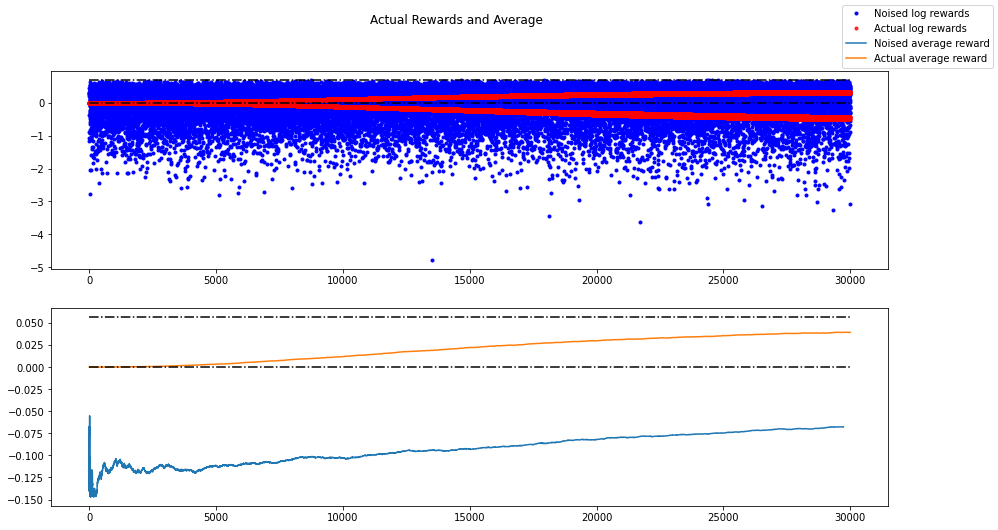

In [285]:
theoretical_best = 2/3*(np.log(2/3)-np.log(1/2)) + 1/3*(np.log(1/3)-np.log(1/2))
empirical_best = np.mean(reward_history[-100:, 3])
print('Towards best ratio: ', empirical_best/ theoretical_best)
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(reward_history[:, 0], 'b.',label = 'Noised log rewards', zorder=-100)
axs[0].plot(reward_history[:, 2], 'r.',label = 'Actual log rewards', zorder=-99, alpha=0.8)
axs[1].plot(not_outlier(reward_history[:, 1]),zorder= -100, label = 'Noised average reward')
axs[1].plot(not_outlier(reward_history[:, 3]),zorder= -99, label = 'Actual average reward')
axs[0].hlines(y=np.log(2), xmin=0, xmax=reward_history.shape[0], colors='black', linestyles='dashdot')
axs[0].hlines(y=0.0, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
axs[1].hlines(y=0.0, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
axs[1].hlines(y=theoretical_best, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Actual Rewards and Average')

Text(0.5, 1.0, 'Approximated value and Actual value')

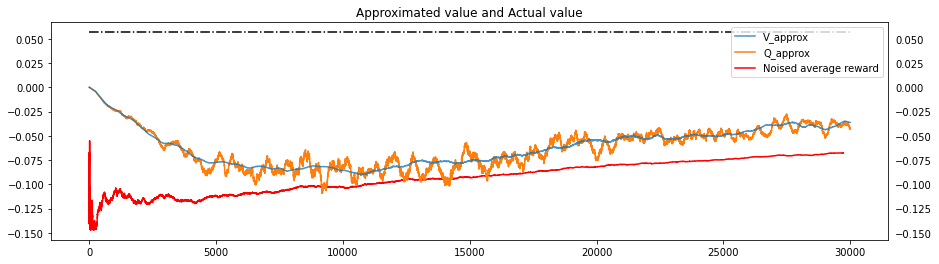

In [286]:
fig = plt.figure(figsize=(15, 4))
plt.plot(qv_array[:, 0], zorder = -99, label = 'V_approx', alpha=0.8)
plt.plot(qv_array[:, 1], zorder= -100, label = 'Q_approx')
[ax] = fig.axes
ax.tick_params(labelright=True)
plt.plot(not_outlier(reward_history[:, 1]), 'r', zorder= -101, label = 'Noised average reward' )
plt.hlines(y=theoretical_best, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
# plt.hlines(y=np.log(2), xmin=0, xmax=reward_history.shape[0], colors='black', linestyles='dashdot')
# plt.hlines(y=0.0, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
plt.legend()
plt.title('Approximated value and Actual value')

15066


Text(0.5, 1.0, 'Report')

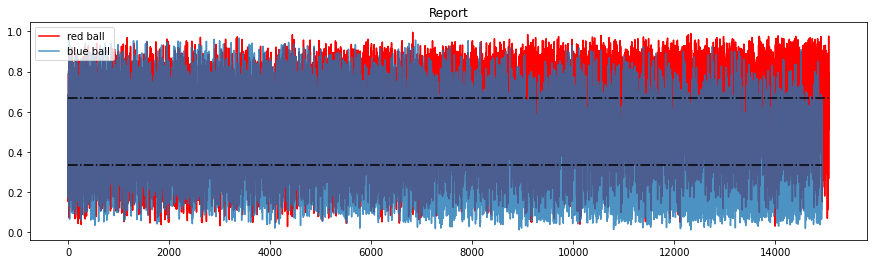

In [287]:
print(len(r_ball_pred_history_list))
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_pred_history_list, 'r',zorder=-100, label='red ball')
plt.plot(b_ball_pred_history_list, zorder=-99, label = 'blue ball', alpha=0.8)
plt.hlines(y=2/3, xmin=0, xmax=len(r_ball_pred_history_list), colors='black', linestyles='dashdot')
plt.hlines(y=1/3, xmin=0, xmax=len(b_ball_pred_history_list) , colors='black', linestyles='dashdot')
plt.legend()
plt.title('Report')

In [288]:
print(expit(agent.report([1, 0, 0.5])))

0.6780115497421756


In [289]:
print(expit(agent.report([0, 1, 0.5])))

0.3028597949365073


In [290]:
if explorer.learning:
    fig = plt.figure(figsize=(15, 4))
    plt.plot(explorer_std_list)
    plt.title('Explorer Standard Diviation')

Text(0.5, 1.0, 'Mean')

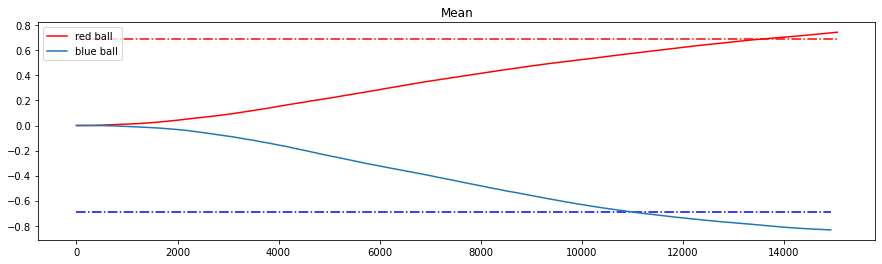

In [291]:
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_mean_history_list, 'r', label = 'red ball')
plt.plot(b_ball_mean_history_list,label = 'blue ball')
plt.hlines(y=np.log(2), xmin=0, xmax=len(r_ball_mean_history_list), colors='red', linestyles='dashdot')
plt.hlines(y=np.log(1/2), xmin=0, xmax=len(b_ball_mean_history_list) , colors='blue', linestyles='dashdot')
plt.legend()
plt.title('Mean')

Text(0.5, 1.0, 'Weights for Mean')

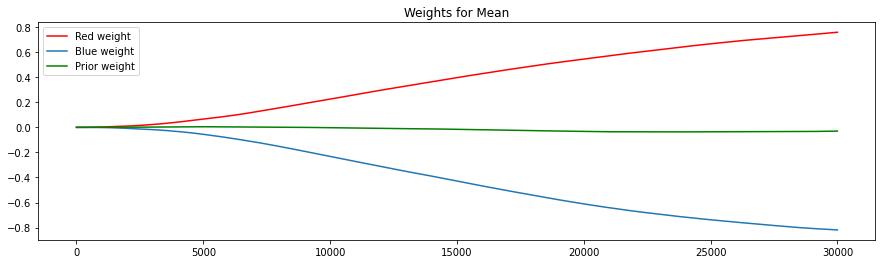

In [292]:
fig = plt.figure(figsize=(15, 4))
plt.plot(mean_weights_history[1:, 0], 'r', label='Red weight')
plt.plot(mean_weights_history[1:, 1], label='Blue weight')
plt.plot(mean_weights_history[1:, 2], 'g', label='Prior weight')
plt.legend()
plt.title('Weights for Mean')

Text(0.5, 0.98, 'Signal Mean Gradients')

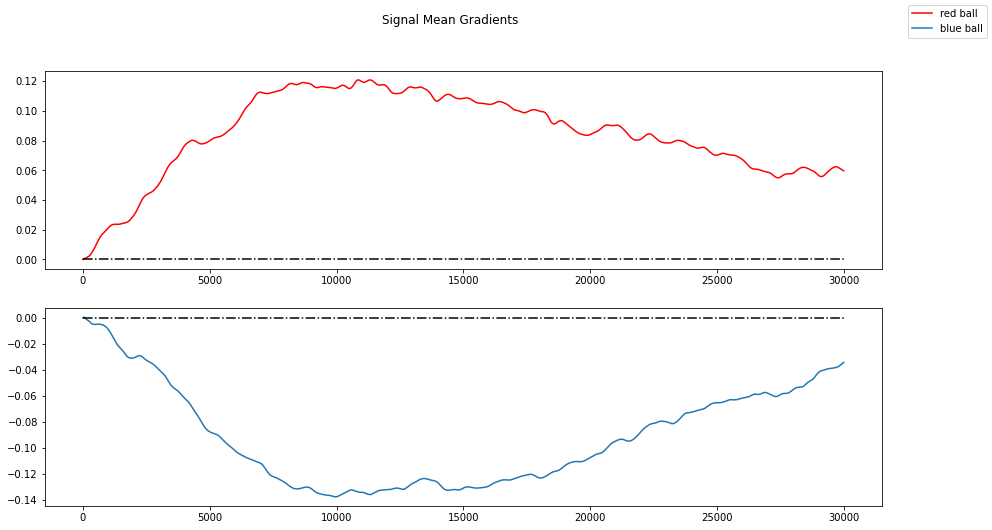

In [293]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_mean_history, 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_mean_history,label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients')

Text(0.5, 0.98, 'Signal Mean Gradients (momentum)')

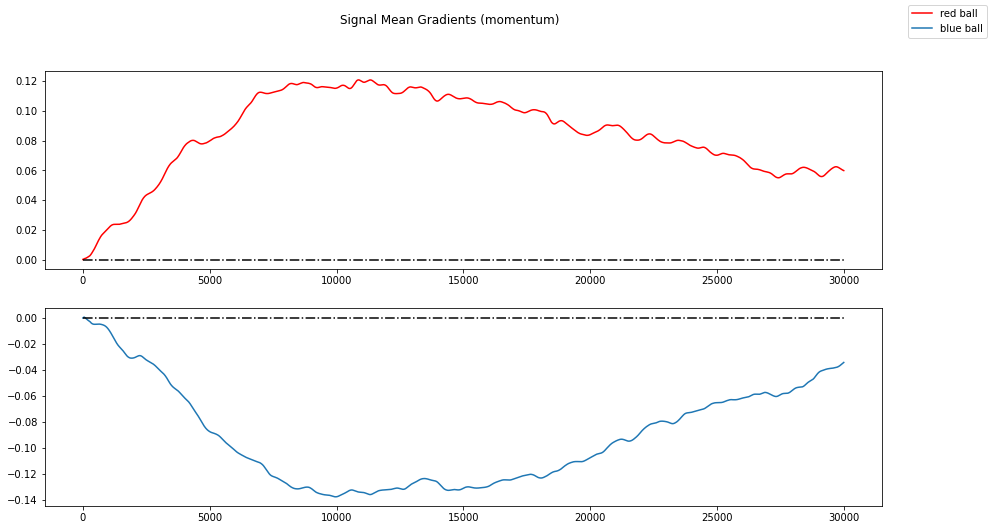

In [294]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_mean_history, 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_v_mean_history,label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (momentum)')

Text(0.5, 0.98, 'Signal Mean Gradients (Adam)')

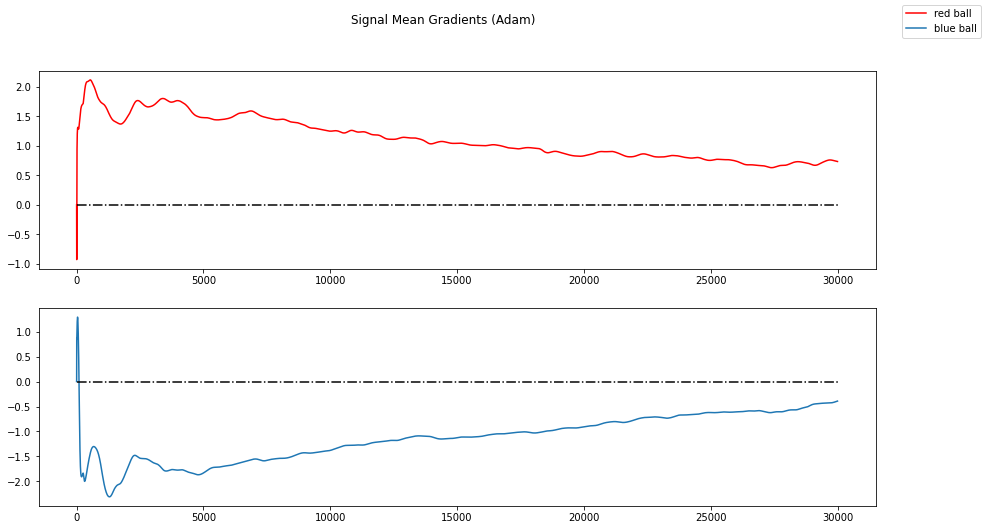

In [295]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_adam_mean_history, 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_adam_mean_history,label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (Adam)')

In [296]:
# fig, axs = plt.subplots(2, figsize=(15, 8))
# axs[0].plot(grad_r_ball_mean_history[:, 2], 'r', label = 'red ball', zorder = -100)
# axs[1].plot(grad_b_ball_mean_history[:, 2],label = 'blue ball', zorder = -100)
# axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
# axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
# fig.legend()
# fig.suptitle('Prior Mean Gradient')

In [297]:
# fig, axs = plt.subplots(2, figsize=(15, 8))
# axs[0].plot(grad_r_ball_v_mean_history[:, 2], 'r', label = 'red ball', zorder = -100)
# axs[1].plot(grad_b_ball_v_mean_history[:, 2],label = 'blue ball', zorder = -100)
# axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
# axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
# fig.legend()
# fig.suptitle('Prior Mean Gradient (Momentum)')